In [1]:
# Some dependencies, you may need to install them, if you do then uncomment the following lines
#using Pkg
#Pkg.add("Plots")
#Pkg.add("Symbolics")
#Pkg.add("DataFrames")
using Symbolics
using DataFrames
using Plots

## Error metrics

In [2]:
function error_metric(xaprox::Float64, xtarget::Float64, is_absolute::Bool)
    
    """
        This function calculates the error between the aproximation and the real value
        

        Parameters
        ----------
        xaprox: Float64, The aproximation of the of the function.
        xtarget: Float64, The real value we want.
        is_absolute: Bool, If true then the error is absolute, if false then the error is relative.

        Returns
        -------
        Float64, The error between the aproximation and the real value of the root of the function.
    """
    
    if is_absolute
        return abs(xtarget - xaprox) 
    else
        return abs(xtarget - xaprox)/xtarget
    end
    
end

error_metric (generic function with 1 method)

## Fake position and bisection

In [3]:

function loop_and_search(f::Function, update_c::Function, a::Float64, b::Float64, tol::Float64, max_iter::Int64, target_value::Float64, is_absolute_error::Bool)
    
    
    """
    This function finds the root of a function f using the way of updating the midpoint c, 
    given by update_c and the interval [a,b]. The tolerance is given by tol. 
    The maximum number of iterations is given by max_iter.

    Parameters:
    ------------
        f: function which we want to find the root for
        update_c: function which updates the value of c (the midpoint, which should be very close to the root)
        a: left endpoint of the interval
        b: right endpoint of the interval
        tol: tolerance for the root
        max_iter: maximum number of iterations

        
    Returns:
    ------------
        c: midpoint of the interval, which should be very close to the root of f
        iters: number of iterations needed to find the root
    """

    c = update_c(f, a, b)
    value = f(c)
    iters = 1

    while (error_metric(value, target_value, is_absolute_error) > tol) && (iters < max_iter)

        if (value*f(a) < 0)
            b = c 
        elseif (value*f(b) < 0)
            a = c
        end

        c = update_c(f, a, b)
        value = f(c)
        iters += 1
    end

    return c, iters
end

loop_and_search (generic function with 1 method)

In [4]:

function update_c_bisection(f::Function, a::Float64, b::Float64)
    return (a+b)/2
end

update_c_bisection (generic function with 1 method)

In [5]:

function update_c_fake_position(f::Function, a::Float64, b::Float64)
    return (b - (f(b)*(b-a))/(f(b) - f(a)))
end

update_c_fake_position (generic function with 1 method)

In [6]:
function bisection_method(f::Function,
                          lower_bound::Float64,
                          upper_bound::Float64,
                          tol::Float64,
                          max_iter::Integer,
                          target_value::Float64,
                          is_absolute_error::Bool)
    return loop_and_search(f, update_c_bisection, lower_bound, upper_bound, tol, max_iter, target_value, is_absolute_error)
end 

function bisection_method_wrapper(f::Function,
                                  df::Function,
                                  x0::Float64,
                                  lower_bound::Float64,
                                  upper_bound::Float64,
                                  tol::Float64,
                                  max_iter::Integer,
                                  target_value::Float64,
                                  is_absolute_error::Bool)

    """
        This function is an standard wrapper for the bisection method. Some of the parameters won't be used, yet we 
        ask for them to be able to use it in the same way as the other methods. Whenever we later want to callit along 
        with the other methods.

        It calls the function loop_and_search with the corresponding parameters.
    """

    return loop_and_search(f, update_c_bisection, lower_bound, upper_bound, tol, max_iter, target_value, is_absolute_error)

end

bisection_method_wrapper (generic function with 1 method)

In [7]:
function fake_position(f::Function,
                       lower_bound::Float64,
                       upper_bound::Float64,
                       tol::Float64,
                       max_iter::Integer,
                       target_value::Float64,
                       is_absolute_error::Bool)
    return loop_and_search(f, update_c_fake_position, lower_bound, upper_bound, tol, max_iter, target_value, is_absolute_error)
end

function fake_position_wrapper(f::Function,
                               df::Function,
                               x0::Float64,
                               lower_bound::Float64,
                               upper_bound::Float64,
                               tol::Float64,
                               max_iter::Integer, 
                               target_value::Float64,
                               is_absolute_error::Bool)
    """
        This function is an standard wrapper for the fake position method. Some of the parameters won't be used, yet we 
        ask for them to be able to use it in the same way as the other methods. Whenever we later want to callit along 
        with the other methods.

        It calls the function loop_and_search with the corresponding parameters.
    """

    return loop_and_search(f, update_c_fake_position, lower_bound, upper_bound, tol, max_iter, target_value, is_absolute_error)
    
end

fake_position_wrapper (generic function with 1 method)

## Fixed point iteration

In [8]:
function check_constraints(f::Function, lower_bound::Float64, upper_bound::Float64)::Bool
   
    slope = abs( (f(upper_bound) - f(lower_bound))/(upper_bound-lower_bound) )

    if slope > 1
        return false
    else
        return true
    end
end

check_constraints (generic function with 1 method)

In [49]:
function fixed_point_iteration(f::Function,
                               x0::Float64,
                               lower_bound::Float64,
                               upper_bound::Float64,
                               tol::Float64,
                               maxiter::Int64, 
                               target_value::Float64,
                               is_absolute_error::Bool)
    
    if  !check_constraints(f, lower_bound, upper_bound)
        println("The function does not meet the requirements for the fixed point iteration method")
        return x0, maxiter
    end

    x = x0

    for i in 1:maxiter
        x = f(x)

        if (x - tol) < lower_bound || (x + tol) > upper_bound
            break

        elseif error_metric(x, target_value, is_absolute_error) < tol
            return x, i
        end
    end

    return x, maxiter
end

function fixed_point_iteration_wrapper(f::Function,
                                       df::Function,
                                       x0::Float64,
                                       lower_bound::Float64,
                                       upper_bound::Float64,
                                       tol::Float64,
                                       max_iter::Integer,
                                       target_value::Float64,
                                       is_absolute_error::Bool)

    """
        This function is an standard wrapper for the fixed point iteration method. Some of the parameters won't be used, yet we 
        ask for them to be able to use it in the same way as the other methods. Whenever we later want to callit along 
        with the other methods.

        It calls the function fixed_point_iteration with the corresponding parameters.
    """

    return fixed_point_iteration(f, x0, lower_bound, upper_bound, tol, max_iter, target_value, is_absolute_error)
end 


fixed_point_iteration_wrapper (generic function with 1 method)

## Newton Rapson

In [10]:
function newton_rapson_method(f::Function, df::Function, x0::Float64, tol::Float64, maxiter::Integer, target_value::Float64, is_absolute_error::Bool)

    x = x0
    for i in 1:maxiter
        x = x - f(x)/df(x)
        if error_metric(f(x), target_value, is_absolute_error) < tol
            return x, i
        end
    end
    return x, maxiter
end

function newton_rapson_method_wrapper(f::Function,
                                      df::Function,
                                      x0::Float64,
                                      lower_bound::Float64,
                                      upper_bound::Float64,
                                      tol::Float64,
                                      max_iter::Integer,
                                      target_value::Float64,
                                      is_absolute_error::Bool)
    """
        This function is an standard wrapper for the newton rapson method. Some of the parameters won't be used, yet we 
        ask for them to be able to use it in the same way as the other methods. Whenever we later want to callit along 
        with the other methods.

        It calls the function newton_rapson_method with the corresponding parameters.
    """

    return newton_rapson_method(f, df, x0, tol, max_iter, target_value, is_absolute_error)
end                                       

newton_rapson_method_wrapper (generic function with 1 method)

## Secant Method

In [11]:
function check_root_in_the_middle(f::Function, x0::Float64, x1::Float64)::Bool
    if f(x0) * f(x1) > 0
        return false
    else
        return true
    end
end

function find_segment_root(f::Function, x0::Float64, x1::Float64)::Float64
    """
        Finds the root of the segments that join (x0, f(x0)) and (x1, f(x1))
    """
    return x1 - f(x1) * (x1 - x0) / (f(x1) - f(x0))
end

find_segment_root (generic function with 1 method)

In [12]:
function secant_method(f::Function,
                       x0::Float64,
                       x1::Float64,
                       tol::Float64,
                       maxiter::Int64,)
    """
        Finds the root of a function using the secant method.
        returns: the final [x0, x1] interval where the root is located.
    """
    
    if !check_root_in_the_middle(f, x0, x1)
        return x0, maxiter
    end

   for i in 1:maxiter
        x2 = find_segment_root(f, x0, x1)
        x0 = x1
        x1 = x2

        if abs(f(x1) - f(x0)) < tol
            return x1, i
        end
    end

    return x1, maxiter
end

function secant_method_wrapper(f::Function,
                               df::Function,
                               x0::Float64,
                               lower_bound::Float64,
                               upper_bound::Float64,
                               tol::Float64,
                               max_iter::Integer, 
                               target_value::Float64,
                               is_absolute_error::Bool)
    """
        This function is an standard wrapper for the secant method. Some of the parameters won't be used, yet we 
        ask for them to be able to use it in the same way as the other methods. Whenever we later want to callit along 
        with the other methods.

        The parameters that are not used are:
            - df: the derivative of the function
            - x0: the initial guess
            - is_absolute_error: if the error is absolute or relative (because the secant method has his own way of calculating the error)
        It calls the function newton_rapson_method with the corresponding parameters.
    """

    return secant_method(f, lower_bound, upper_bound, tol, max_iter)
end                                       

secant_method_wrapper (generic function with 1 method)


## 1. (valor 2pts) Emplear los métodos de solución de ecuaciones de una variable para dar solución a las siguientes ecuaciones:

1. $e^x − 4 + x = 0$
2. $x − 0.2 sin(x) − 0.5 = 0$
3. $\displaystyle e^{\frac{x}{2}} − x^2 − 3x = 0$
4. $e^x cos(x) − x^2 + 3x = 0$
5. $0.5x^3 + x^2 − 2x − 5 = 0$
6. $e^x − 4x^2 − 8x = 0$

In [13]:
@variables x
f1sym = exp(x) - 4 + x
f2sym = x - 0.2*Symbolics.sin(x) - 0.5
f3sym = exp(x/2) - x^2 - 3*x
f4sym = exp(x)*Symbolics.cos(x) - x^2 + 3x
f5sym = 0.5*x^3 + x^2 - 2*x - 5
f6sym = exp(x) - 4*x^2 - 8*x

fn = [f1sym, f2sym, f3sym, f4sym, f5sym, f6sym]

6-element Vector{Num}:
         x + exp(x) - 4
        x - 0.5 - 0.2sin(x)
             exp((1//2)*x) - 3x - (x^2)
 3x + cos(x)*exp(x) - (x^2)
      x^2 + 0.5(x^3) - 5 - 2x
             exp(x) - 8x - 4(x^2)

In [14]:
derivatives = [Symbolics.derivative(f, x) for f in fn]

6-element Vector{Num}:
        1 + exp(x)
       1 - 0.2cos(x)
     (1//2)*exp((1//2)*x) - 3 - 2x
 3 + cos(x)*exp(x) - 2x - exp(x)*sin(x)
      2x + 1.5(x^2) - 2
            exp(x) - 8 - 8x

In [15]:
compiledf = [Symbolics.build_function(f, x, expression = false) for f in fn]
compileddf = [Symbolics.build_function(df, x, expression = false) for df in derivatives]

6-element Vector{RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:x,), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", id, Expr} where id}:
 RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:x,), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xa9d56c03, 0xf763ce0d, 0x69b02d88, 0xcb0eacb9, 0xc42076d2), Expr}(quote
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#
    (+)(1, (exp)(x))
end)
 RuntimeGeneratedFunctions.RuntimeGeneratedFunction{(:x,), Symbolics.var"#_RGF_ModTag", Symbolics.var"#_RGF_ModTag", (0xa1abfe37, 0xd0223307, 0x7cd529de, 0xd4371e2a, 0x330b6ea7), Expr}(quote
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
    #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#


Ahora que tenemos nuestras funciones y sus derivadas compiladas podemos felizmente tratar de mirar hacia dónde convergen, y hacernos una idea sobre los métodos. Haremos dos tests, el primero es en "igualdad" de condiciones iniciales, es decir, todas van a empezar con los mismos:

- intervalos
- puntos iniciales
- tolerancia
- máximo número de iteraciones

Con esto buscamos evaluar qué tanto nos pueden servir las funciones en un primer intento asumiendo que no podemos saber mucho sobre la función y que por lo tanto no podemos escoger unos mejores puntos iniciales, o intervalos.

In [16]:
x = 0.1 # Initial guess
lower_bound = -50.0
upper_bound = 50.0
tol = 1e-4
max_iter = 1000
target_value = 0.0

methods = [(bisection_method_wrapper, "Bisection"), (fake_position_wrapper, "Fake position"),
           (fixed_point_iteration_wrapper, "Fixed point iteration"), (newton_rapson_method_wrapper, "Newton rapson"), 
           (secant_method_wrapper, "Secant method")]

#run all the methods for all the functions
results = []

for i in 1:length(fn)
    for method in methods
        push!(results, method[1](compiledf[i], compileddf[i], x, lower_bound, upper_bound, tol, max_iter, target_value, true))
    end
end

Tenga en cuenta que si en alguna función se llegó al máximo de iteraciones (1000) puede que haya tenido grandes problemas convergiendo, y si además el x al que llegó es el x0 (0.1) entonces esto se traduce en que no pasó de la primera iteración por que no cumplía condiciones.

In [17]:
performances = DataFrame(name = [methods[2] for i in 1:length(fn) for methods in methods],
                         x = [results[i][1] for i in 1:length(results)],
                         iterations = [results[i][2] for i in 1:length(results)])

#sort by name and then by iterations
#sort!(performances, [:name, :x])
show(performances, allrows=true)

30×3 DataFrame
 Row │ name                   x           iterations 
     │ String                 Float64     Int64      
─────┼───────────────────────────────────────────────
   1 │ Bisection                1.07374           20
   2 │ Fake position          -50.0             1000
   3 │ Fixed point iteration    0.1             1000
   4 │ Newton rapson            1.07373            4
   5 │ Secant method          -50.0                2
   6 │ Bisection                0.615501          19
   7 │ Fake position            0.615376           5
   8 │ Fixed point iteration    0.1             1000
   9 │ Newton rapson            0.615474           2
  10 │ Secant method            0.615468           5
  11 │ Bisection               -3.07016           20
  12 │ Fake position          -49.9967          1000
  13 │ Fixed point iteration    0.1             1000
  14 │ Newton rapson            0.356029           3
  15 │ Secant method           -3.07017           14
  16 │ Bisection            

### Análisis de resultados (Punto 1)

AAAAAAAAAAAAAAAAAAAAAA hay que escribir carreta

### 2. (valor 1pts) La velocidad de una paracaidista se define como:

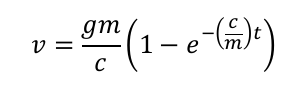

Teniendo presente que el valor aproximado de la gravedad es de $9.81m/s^2$, emplee el método de bisección y de falsa posición, con un error inferior a $ε_{rr} ≤ 0.02\%$ para:

1. Calcular el valor de la masa que hace que el paracaidista tenga una velocidad de $v = 36m/s$, con un coeficiente de resistencia $c = 15kg/s$ en un tiempo $t = 10s$.

In [18]:
g = 9.81 #m/s^2
c = 15.0 #kg/s
t = 10.0 #s
v = 36.0 #m/s

@variables m
eqn1 = (((g*m)/c) * (1 - exp(-(c/m)*t))) - v

0.654m*(1 - exp(-10.0(15.0 / m))) - 36.0

In [19]:
eqn1compiled = Symbolics.build_function(eqn1, m, expression = false)
eqn1dfcompiled = Symbolics.build_function(Symbolics.derivative(eqn1, m), m, expression = false)

RuntimeGeneratedFunction(#=in Symbolics=#, #=using Symbolics=#, :((m,)->begin
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#
          (+)((*)(0.654, (+)(1, (*)(-1, (exp)((*)(-10.0, (/)(15.0, m)))))), (*)((*)((*)(-6.54, m), (/)(15.0, (^)(m, 2))), (exp)((*)(-10.0, (/)(15.0, m)))))
      end))

In [20]:
lowerbound = 20.0
upperbound = 100.0
tol = 0.02/100
maxiter = 100

fake_position(eqn1compiled, lowerbound, upperbound, tol, maxiter, 1e-10, false)

(59.95927973739916, 100)

In [21]:
bisection_method(eqn1compiled, lowerbound, upperbound, tol, maxiter, 1e-10, false)

(59.95927973739916, 100)

In [22]:
newton_rapson_method(eqn1compiled, eqn1dfcompiled, 50.0, tol, maxiter, 1e-10, false)

(59.95927973739916, 100)

2. Calcular el valor del coeficiente de resistencia para que un paracaidista de 82kg tenga una velocidad de $36m/s$ después de $4s$ de caída libre.

In [23]:
g = 9.81 #m/s^2
m = 80.0 #kg
t = 4.0 #s
v = 36.0 #m/s

@variables c
eqn2 = (((g*m)/c) * (1 - exp(-(c/m)*t))) - v

(784.8000000000001(1 - exp(-0.05c))) / c - 36.0

In [24]:
eqn2compiled = Symbolics.build_function(eqn2, c, expression = false)
eqn2dfcompiled = Symbolics.build_function(Symbolics.derivative(eqn2, c), c, expression = false)

RuntimeGeneratedFunction(#=in Symbolics=#, #=using Symbolics=#, :((c,)->begin
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#
          (+)((/)((*)(39.24000000000001, (exp)((*)(-0.05, c))), c), (/)((*)(-784.8000000000001, (+)(1, (*)(-1, (exp)((*)(-0.05, c))))), (^)(c, 2)))
      end))

In [25]:
lowerbound = 1.0
upperbound = 50.0
tol = 0.02/100
maxiter = 100

fake_position(eqn2compiled, lowerbound, upperbound, tol, maxiter, 1e-10, false)

(3.498080556491513, 100)

In [26]:
bisection_method(eqn2compiled, lowerbound, upperbound, tol, maxiter, 1e-10, false)

(3.4980805564915203, 100)

In [27]:
newton_rapson_method(eqn2compiled, eqn2dfcompiled, 50.0, tol, maxiter, 1e-10, false)

(3.4980805564915056, 100)

### 3. (valor 2pts) Encuentre el máximo de la siguiente función con un error inferior al $\epsilon_{rr} \leq 0.05\%$:

$$f(x) = -2x^6 -1.5x^4 + 10x + 2$$

a. Emplee el método de iteración de punto fijo.    
b. Emplee el método de Newton – Raphson iniciando en $x_i = 1$.     
c. Emplee el método de la secante a partir de $x_{i−1} = 0$ y $x_{i} = 1$.     
d. Independiente de la convergencia, seleccione la técnica más adecuada para este problema. Justifique su respuesta.

In [30]:
@variables x
f7sym = -2*x^6 - 1.5*x^4 + 10*x + 2

2 + 10x - 1.5(x^4) - 2(x^6)

In [75]:
compiledf7 = Symbolics.build_function(f7sym, x, expression = false)
compileddf7 = Symbolics.build_function(Symbolics.derivative(f7sym, x), x, expression = false)
compiledddf7 = Symbolics.build_function(Symbolics.derivative(Symbolics.derivative(f7sym, x), x), x, expression = false)

RuntimeGeneratedFunction(#=in Symbolics=#, #=using Symbolics=#, :((x,)->begin
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:373 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:374 =#
          #= /home/dave/.julia/packages/SymbolicUtils/Oyu8Z/src/code.jl:375 =#
          (+)((*)(-18.0, (^)(x, 2)), (*)(-60, (^)(x, 4)))
      end))

Probamos iteración de punto fijo (lo intentamos mucho pero sin mucho éxito):

In [73]:
x0 = 0.87
lower_bound = 0.870
upper_bound = 0.875
tol = 0.05/100
max_iter = 100
target_value = 1e-10

fixed_point_iteration(compileddf7, x0, lower_bound, upper_bound, tol, max_iter, target_value, false)

The function does not meet the requirements for the fixed point iteration method


(0.87, 100)

In [76]:
x0 = 1.0 
lower_bound = 0.1
upper_bound = 2.0
tol = 0.05/100
max_iter = 100
target_value = 1e-10

newton_rapson_method(compileddf7, compiledddf7, x0, tol, max_iter, target_value, false)

(0.8714113505667633, 100)

In [77]:
x0 = 0.001
lower_bound = 0.0
upper_bound = 1.0
tol = 0.05/100
max_iter = 100
target_value = 1e-10

secant_method(compileddf7, lower_bound, upper_bound, tol, max_iter)

(0.8714113505273179, 8)

El orden en que seleccionaríamos métodos sería:

1. Newton rapson, esta es nuestra herramienta más conveniente cuando conocemos la ecuación del sistema, y no es particularmente compleja para derivar, aquí tenemos una función polinómica, una delicia de derivar para cualquiera. Además es el que converge más rápido para todos los métodos cuando testeamos en el punto 1 (cuando usamos errores relativos muy pequeños hacemos que esto prácticamente nunca converja).

2. Secante y luego la iteración de punto fijo como última opción, esto por que es una tarea de adivinar (o brutforcear o conocer la gráfica) para seleccionar un buen intervalo que cumpla la restricción de tener una pendiente menor a 1. Básicamente secante es nuestra segunda opción por que iteración por punto fijo es nuestra última opción. además funciona bastante bien.

### 4. (valor 1pts) Para la siguiente tabla de datos:


1. Encuentre el polinomio interpolador de Lagrange que pasa por los puntos de la tabla
de datos.
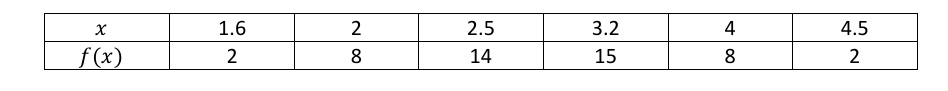

2. Grafique la tabla de datos y el polinomio interpolador obtenido. 

3. Calcule el valor de f(2.8)

In [29]:

function lagrange_coefficients(xvalue::Float64, x::Vector, k::Int)::Float64

    n = length(x)
    numerator = 1
    denominator = 1

    for j = 1:n
        if j != k
            numerator = numerator * (xvalue - x[j])
            denominator = denominator * (x[k] - x[j])
        end
    end

    return numerator / denominator
end

function lagrange_polynomial(points::Vector{Vector{Float64}}, x::Float64)
    """
    Polynomial Interpolation, with lagrange polynomials.

    Parameters
    ----------
    points: list of points [x, y] to interpolate.
    x: point to interpolate.
    
    Returns
    -------
    y: interpolated value.
    """

    y = 0.0
    xpoints = [points[i][1] for i in 1:length(points)]
    ypoints = [points[i][2] for i in 1:length(points)]

    for k in 1:length(points)
        pointx = xpoints[k]
        pointy = ypoints[k]

        y += pointy * lagrange_coefficients(x, xpoints, k)
    end

    return y 
end

lagrange_polynomial (generic function with 1 method)